In [1]:
include("MySimplexQuad.jl")
using .MySimplexQuad

include("OrthoPols.jl")
using .OrthoPols

use_bigfloat = false

###############################################################

function rse(vec::Vector{T}) where T
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################


function Trans(point::Vector{T}) where T
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # (0,0) maps to this
    v2 = T[ 1, -1 / sqrt(T(3))]   # (1,0) maps to this
    v3 = T[ 0,  2 / sqrt(T(3))]   # (0,1) maps to this
    
    # Extract x and y from the input point
    x, y = point

    # Compute the affine transformation
    new_x = (v2[1] - v1[1]) * x + (v3[1] - v1[1]) * y + v1[1]
    new_y = (v2[2] - v1[2]) * x + (v3[2] - v1[2]) * y + v1[2]

    return T[new_x, new_y]
end

function TransJ()
    # Determine the type based on the global variable
    T = use_bigfloat ? BigFloat : Float64

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]
    v2 = T[ 1, -1 / sqrt(T(3))]
    v3 = T[ 0,  2 / sqrt(T(3))]
    
    # Compute the Jacobian matrix
    J = T[
        v2[1] - v1[1]  v3[1] - v1[1];
        v2[2] - v1[2]  v3[2] - v1[2]
    ]
    
    return J
end

function TransBack(point::Vector{T}) where T
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # Maps to (0,0)
    v2 = T[ 1, -1 / sqrt(T(3))]   # Maps to (1,0)
    v3 = T[ 0,  2 / sqrt(T(3))]   # Maps to (0,1)
    
    # Extract x and y from the input point
    x, y = point

    # Compute the inverse affine transformation
    denominator = (v1[1] * (v2[2] - v3[2]) + v2[1] * (v3[2] - v1[2]) + v3[1] * (v1[2] - v2[2]))
    
    new_x = ((v2[2] - v3[2]) * (x - v1[1]) + (v3[1] - v2[1]) * (y - v1[2])) / denominator
    new_y = ((v3[2] - v1[2]) * (x - v2[1]) + (v1[1] - v3[1]) * (y - v2[2])) / denominator

    return T[new_x, new_y]
end

function TransBackJ()
    # Determine the type based on the global variable
    T = use_bigfloat ? BigFloat : Float64

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # Maps to (0,0)
    v2 = T[ 1, -1 / sqrt(T(3))]   # Maps to (1,0)
    v3 = T[ 0,  2 / sqrt(T(3))]   # Maps to (0,1)
    
    # Compute the denominator
    denominator = (v1[1] * (v2[2] - v3[2]) + v2[1] * (v3[2] - v1[2]) + v3[1] * (v1[2] - v2[2]))
    
    # Compute the Jacobian matrix
    J = T[(v2[2] - v3[2]) / denominator  (v3[1] - v2[1]) / denominator;
          (v3[2] - v1[2]) / denominator  (v1[1] - v3[1]) / denominator]
    
    return J
end

###############################################################

TransBackJ (generic function with 1 method)

In [3]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches


freeparam = 1
order = 4
# indices = [1,4,6,8,10,11,13,15]
indices = 1:15

###############################################################

function (vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)
###############################################################


# vertices
T1 = hcat(p1, p2, p3)
eval_T1(order) = (ortho2eva3(order, Trans(T1[:,1]))[1])+
                 (ortho2eva3(order, Trans(T1[:,2]))[1])+
                 (ortho2eva3(order, Trans(T1[:,3]))[1])

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(order) = (ortho2eva3(order, Trans(T2[:,1]))[1])+
                 (ortho2eva3(order, Trans(T2[:,2]))[1])+
                 (ortho2eva3(order, Trans(T2[:,3]))[1])

# midpoint
T3 = hcat(b)
eval_T3(order) = (ortho2eva3(order, Trans(T3[:,1]))[1])


# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

dT4 = hcat(p1.-p2,
           p2.-p1,
           p3.-p1,
           p1.-p3,
           p3.-p2,
           p2.-p3)

eval_T4(order,a) = (ortho2eva3(order, Trans(T4(a)[:,1]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,2]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,3]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,4]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,5]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,6]))[1])

eval_dT4(order,a) = ([ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1]))'

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1,
             a * m2 .+ (1 .- a) * p2,
             a * m3 .+ (1 .- a) * p3)

dT5 = hcat(m1-p1,
           m2-p2,
           m3-p3)

eval_T5(order,a) = ortho2eva3(order, Trans(T5(a)[:,1]))[1]+
                   ortho2eva3(order, Trans(T5(a)[:,2]))[1]+
                   ortho2eva3(order, Trans(T5(a)[:,3]))[1]

eval_dT5(order,a) = ([ortho2eva3(order, Trans(T5(a)[:,1]))[2], ortho2eva3(order, Trans(T5(a)[:,1]))[3]]'*TransJ()*(dT5[:,1])+
                     [ortho2eva3(order, Trans(T5(a)[:,2]))[2], ortho2eva3(order, Trans(T5(a)[:,2]))[3]]'*TransJ()*(dT5[:,2])+
                     [ortho2eva3(order, Trans(T5(a)[:,3]))[2], ortho2eva3(order, Trans(T5(a)[:,3]))[3]]'*TransJ()*(dT5[:,3]))'


# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

daT6(b) = hcat(b * (m1 - p1) + (1 - b) * (m2 - p2),
               b * (m1 - p1) + (1 - b) * (m3 - p3),
               b * (m3 - p3) + (1 - b) * (m2 - p2),
               b * (m2 - p2) + (1 - b) * (m1 - p1),
               b * (m3 - p3) + (1 - b) * (m1 - p1),
               b * (m2 - p2) + (1 - b) * (m3 - p3))

dbT6(a) = hcat((a * m1 + (1 - a) * p1) - (a * m2 + (1 - a) * p2),
               (a * m1 + (1 - a) * p1) - (a * m3 + (1 - a) * p3),
               (a * m3 + (1 - a) * p3) - (a * m2 + (1 - a) * p2),
               (a * m2 + (1 - a) * p2) - (a * m1 + (1 - a) * p1),
               (a * m3 + (1 - a) * p3) - (a * m1 + (1 - a) * p1),
               (a * m2 + (1 - a) * p2) - (a * m3 + (1 - a) * p3))

eval_T6(order,a,b) = ortho2eva3(order, Trans(T6(a, b)[:,1]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,2]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,3]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,4]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,5]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,6]))[1]

eval_daT6(order,a,b) = ([ortho2eva3(order, Trans(T6(a, b)[:,1]))[2], ortho2eva3(order, Trans(T6(a, b)[:,1]))[3]]'*TransJ()*(daT6(b)[:,1])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,2]))[2], ortho2eva3(order, Trans(T6(a, b)[:,2]))[3]]'*TransJ()*(daT6(b)[:,2])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,3]))[2], ortho2eva3(order, Trans(T6(a, b)[:,3]))[3]]'*TransJ()*(daT6(b)[:,3])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,4]))[2], ortho2eva3(order, Trans(T6(a, b)[:,4]))[3]]'*TransJ()*(daT6(b)[:,4])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,5]))[2], ortho2eva3(order, Trans(T6(a, b)[:,5]))[3]]'*TransJ()*(daT6(b)[:,5])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,6]))[2], ortho2eva3(order, Trans(T6(a, b)[:,6]))[3]]'*TransJ()*(daT6(b)[:,6]))'

eval_dbT6(order,a,b) = ([ortho2eva3(order, Trans(T6(a, b)[:,1]))[2], ortho2eva3(order, Trans(T6(a, b)[:,1]))[3]]'*TransJ()*(dbT6(a)[:,1])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,2]))[2], ortho2eva3(order, Trans(T6(a, b)[:,2]))[3]]'*TransJ()*(dbT6(a)[:,2])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,3]))[2], ortho2eva3(order, Trans(T6(a, b)[:,3]))[3]]'*TransJ()*(dbT6(a)[:,3])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,4]))[2], ortho2eva3(order, Trans(T6(a, b)[:,4]))[3]]'*TransJ()*(dbT6(a)[:,4])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,5]))[2], ortho2eva3(order, Trans(T6(a, b)[:,5]))[3]]'*TransJ()*(dbT6(a)[:,5])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,6]))[2], ortho2eva3(order, Trans(T6(a, b)[:,6]))[3]]'*TransJ()*(dbT6(a)[:,6]))'

# System setup
function A(a)
    hcat(
        eval_T1(order)[indices], # trig vertices
        eval_T2(order)[indices], # edge midpoints

        # eval_T4(order,a[1]), # edge class
        # eval_T4(order,a[2]), # edge class
        
        eval_T5(order,a[1])[indices],
        # eval_T5(order,a[4]),
        # eval_T5(order,a[5]),
        
        # eval_T3(order), # trig midpoint
        
        # eval_T6(order,a[6],a[7]),
        # eval_T5(order,a[8]),
    )
end


# works for first order for now ....
function dA(a)
    hcat(
        0*eval_T1(order)[indices],
        0*eval_T2(order)[indices],
        eval_dT5(order,a[1])[indices],
    )
end

function rhs()
    T = use_bigfloat ? BigFloat : Float64
    X, W = mysimplexquad(T, order, 2)
    w = zeros(T, div((order + 1) * (order + 2), 2))[indices]  # Initialize w with the correct type and size
    
    for k = 1:length(W)
        pols = (ortho2eva3(order, Trans(T.(X[k,:])))[1])[indices]
        w .+= 2*W[k] .* pols
    end
    return w
end

f(a) = norm(A(a)*((A(a)' * A(a))\(A(a)' * rhs()))-rhs())
g(a) = A(a)*((A(a)' * A(a))\(A(a)' * rhs()))-rhs()


g (generic function with 1 method)

In [5]:
# a = 0.134
# dq = 0.0000001
# display((A(a.+dq)-A(a.-dq))/(2*dq))

# display(dA(a))

# dA(0.2)

# K(a) = ortho2eva3(order, Trans(T5(a)[:,1]))[1]
# dK(a) = ([ortho2eva3(order, Trans(T5(a)[:,1]))[2], 
#           ortho2eva3(order, Trans(T5(a)[:,1]))[3]]'*TransJ()*(dT5[:,1]))'

# display((K(a.+dq)-K(a.-dq))/(2*dq))
# display(dK(a))

# up(0.38)

In [6]:
A(0.2)
# TransJ()

15×3 Matrix{BigFloat}:
  2.27951        2.27951       2.27951
 -1.60737e-77   -8.03686e-78   3.09954e-16
 -3.45447e-77   -1.72723e-77   1.78952e-16
  5.88566        0.0           1.88341
 -7.87448e-77    9.8431e-78    2.53076e-16
  6.58037       -1.72723e-77   2.10572
 -2.58977e-231   2.60424e-77   1.08471e-15
 -6.79618        5.94665      -0.985446
 -2.27317e-76   -1.13658e-77   7.10112e-16
  3.03934       -2.65942       0.440705
 10.1943         2.54857      -1.95322
 -2.31637e-230  -2.91163e-77  -2.15599e-16
  7.59836        1.89959      -1.45585
 -5.08296e-76    1.27074e-77   9.37033e-16
 11.8933         2.97333      -2.27876

In [23]:
a = 0.2#4/(7 + sqrt(BigFloat("13")))

B(a) = A(a)'*A(a)
C(a) = inv(B(a))
J(a) = dA(a)*C(a)*A(a)'*rhs() -A(a)*C(a)*(dA(a)'*A(a)+A(a)'*dA(a))*C(a)*A(a)'*rhs() +A(a)*C(a)*dA(a)'*rhs()

up(a) = inv(J(a)'*J(a))*J(a)'

m(a) = dA(a)'*A(a)+A(a)'*dA(a)


# display(iJat(0.38))
# x = 0.1:0.001:0.8
# plot()
# plot!(x,f.(x))
# plot!(x,-norm.(J.(x)))

# a = 0.2#4/(7 + sqrt(BigFloat("13")))
# J(a)

C(a)*A(a)'*rhs()

3-element Vector{BigFloat}:
 0.004976851851851846902595350346689863626153619190442339713456034836013471131377492
 0.04897486772486772342628625925716493966824517495411295935039709754635734238130225
 0.1033399470899470805030792539720276460807939500913184407356903627270371720822277

In [9]:
a = 0.8

for i=1:10
    a = a -up(a)*g(a)
    println(a)
end

1.17402597402597396966330444168040310904166449489871478222705293671351690410351
1.178374486806663643199447354490252881640740547282127542009684024672624146094323
1.178394585735442699279020808605743909012348334693032900270525416479337116469079
1.178394586162665476820224659792307763402139681179816968695832656492100312793022
1.17839458616266547701324680749672177176629813051504860116267131867843281077976
1.178394586162665477013246807496721771805699619316138468078939228469685216475357
1.178394586162665477013246807496721771805699619316138468078939228469685216476998
1.178394586162665477013246807496721771805699619316138468078939228469685216476981
1.178394586162665477013246807496721771805699619316138468078939228469685216476981
1.178394586162665477013246807496721771805699619316138468078939228469685216476981


In [186]:
a = 0.134
dq = 0.0000001
# display((A(a.+dq)-A(a.-dq))/(2*dq))

# display(dA(a))

# dA(0.2)

K(a) = ortho2eva3(order, Trans(T6(a, 0.2)[:,1]))[1]
dK(a) = ([ortho2eva3(order, Trans(T6(a, 0.2)[:,1]))[2], 
          ortho2eva3(order, Trans(T6(a, 0.2)[:,1]))[3]]'*TransJ()*(daT6(0.2)[:,1]))'

display((K(a.+dq)-K(a.-dq))/(2*dq))
display(dK(a))

dK (generic function with 1 method)

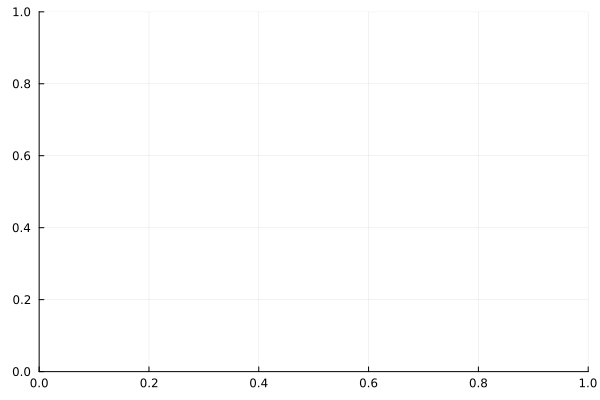

In [121]:
plot()
# x = 0.3:0.001:0.4
# plot!(x,f.(x))
# # plot!(x,f.(x))
# plot!(x,iJat.(x))

In [117]:
# ortho2eva3(order, Trans(T4(a)[:,1]))[2]*dT4[1,1] + ortho2eva3(order, Trans(T4(a)[:,1]))[3]*dT4[2,1]
# eval_daT6(order,0.2,0.1)
# dT4

In [116]:
# using Zygote
# z(x) = 5x + 3


# f(a) = norm(A(a)'*((A(a) * A(a)')\(A(a) * rhs(BigFloat,order)))-rhs(BigFloat,order))
A([0.1, 0.2, 0.1, 0.34, 0.33, 0.32, 0.31])
rhs()
# f'([0.1, 0.2, 0.35, 0.34, 0.33, 0.32, 0.31])
# f'(2.0)

# a = ([0.1, 0.2, 0.35, 0.34, 0.33, 0.32, 0.31])
T4(0.2)
eval_dT4(order,0.6)


15-element Vector{Float64}:
   0.0
   0.0
   0.0
   4.617478023550033
  -2.2795070569547797
   6.078685485212743
   4.824807027615274
 -10.825088811661981
  -4.737866446628977
   5.264296051809977
 -11.484282945891696
   6.257385965398548
  -7.27626598630639
  -0.4943956006722976
 -14.502270953053998

In [119]:
# Define the bounds
# lower_bounds = BigFloat[0.0, 0.0, 0.0]
# upper_bounds = BigFloat[Inf, Inf, Inf]

# Set up the optimization problem with bounds
# result = optimize(f, lower_bounds, upper_bounds, BigFloat[0.1, 0.1, 0.2], Fminbox(NelderMead()), Optim.Options(g_tol = 1e-63, iterations = 100_000, show_trace = false))

# result = optimize(f, 
#             lower_bounds, 
#             upper_bounds, 
#             BigFloat[0.1, 0.2, 0.3],
#             Fminbox(NelderMead()), 
#             Optim.Options(g_tol = 1e-63, iterations = 100_000, show_trace = true, show_every = 100))

In [120]:
# a = Optim.minimizer(result)

# a = BigFloat[0.1, 0.2, 0.3]

min_val = 0.2
max_val = 0.7
a = min_val .+ (max_val - min_val) .* BigFloat.(rand(freeparam))

# display(a)
# display(g(a))
using Plots
plot()
display(A(a,order))

MethodError: MethodError: no method matching A(::Vector{BigFloat}, ::Int64)

Closest candidates are:
  A(::Any)
   @ Main c:\Users\Radu\Documents\GitHub\fem\PROJECTS\quadrature\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:144


In [121]:
# println(a)

# td = TwiceDifferentiable(f, a; autodiff = :forward);

# # result = optimize(td, a, Newton(; linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-100, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))
# # result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

# result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-63, iterations = 50, show_trace = true, show_every = 10, time_limit = 1000))

# println(result)

# a = Optim.minimizer(result)
# using Base.Threads

# using Distributed

# num_runs = 5

# @threads  for i in 1:num_runs

# a = BigFloat[0.3, 0.2, 0.1]

of = TwiceDifferentiable(f, a; autodiff = :forward)
# method = Newton(; linesearch = LineSearches.MoreThuente())
method = Newton(; linesearch = LineSearches.BackTracking(order=3))


# of = OnceDifferentiable(f, a; autodiff = :forward);
# method = GradientDescent()

options = Optim.Options(g_tol = 1e-50, iterations = 20, show_trace = true, show_every = 1, time_limit = 1000)


# lower_bounds = fill(BigFloat("0"), freeparam)
# # upper_bounds = fill(Inf, freeparam)

result = optimize(of, a, method, options)
# # result = optimize(of,lower_bounds, upper_bounds, a, method, options)
a = Optim.minimizer(result)

print(a)

In [ ]:
a = Optim.minimizer(result)
display(f(a))
display(a)

In [ ]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]



# eval_T1(order), # trig vertices
# # eval_T2(order), # edge midpoints

# eval_T4(order,a[1]), # edge class
# eval_T4(order,a[2]), # edge class

# eval_T5(order,a[3]),
# eval_T5(order,a[4]),
# eval_T5(order,a[5]),

# eval_T3(order), # trig midpoint

# eval_T6(order,a[6],a[7]),
# # eval_T5(order,a[8]),




# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T2[1, :], T2[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

# savefig("kek.png")

In [ ]:
vertices = [
    0.0 0.0
    1.0 0.0
    0.0 1.0
]

# Need at least 4 vertices for plotting?
vertices1 = [vertices; vertices[1:1, :]]

using Plots
plot()

# for npoints in [1,2]
npoints = 4
    X, W = mysimplexquad(BigFloat, npoints, 2)

    # Plot the triangle
    plot!(vertices1'[1,:], vertices1'[2,:], seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
    scatter!(X[:, 1], X[:, 2], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)

    # Add plot title and labels
    xlabel!("x")
    ylabel!("y")
# end

In [ ]:
w = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(BigFloat,order)))
rhs(BigFloat,order)
# sum(w)
w
# K = A(a,order)'
# sum(K,dims=2)
# sum(,1)